# The following code presents t-SNE visualization of images using the 4096 features from second-to-last full connected layer. A k-means clustering algorithm is further used to find clusters of image posters. Finally, the code below presents how to visualize the most important features out of the 4096.

### 1. Import libraries

In [ ]:
from sklearn.manifold import TSNE
from ggplot import *
import urllib
import requests

import sqlalchemy

import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from sqlalchemy import Column, Integer, MetaData, Table

import psycopg2
from pathlib import Path

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import re
import string


%pylab inline

pylab.rcParams['figure.figsize'] = (20, 20)

%matplotlib notebook

### 2. Load database in pandas dataframe, read fc2 string and convert to numpy array

In [ ]:
dbname = 'DBName'
username = 'postgres'



engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

metadata = MetaData(engine)

metadata.reflect(bind=engine)


##### Create pandas df from sql database table
with engine.connect() as conn:

    

    select_statement = metadata.tables['FilmTable'].select()

    pdfilm_table_from_sqlnew = pd.read_sql_query(select_statement,conn)
    
   
##### Download images with non "None" values for fc2

pathImageDL="/home/nico/New/Images/"
    
for filein in pdfilm_table_from_sqlnew.poster_path[(pdfilm_table21_from_sqlnew.fc2.str.\
                            contains("None")) == False ]:
    
    
 
    my_file = Path(pathImageDL + filein)
    
   
    if my_file.is_file() == False:
    
        try:
            print ("http://image.tmdb.org/t/p/original/%s" % filein)


            urllib.request.urlretrieve("http://image.tmdb.org/t/p/original/%s" % filein,\
                                   pathImageDL+filein)

        except:
            pass



##### Create arrays to use for storage

posterpathTable=[]

del posterpathTable[:]

posterpathTableOnline=[]

del posterpathTableOnline[:]


genresTable=[]

del genresTable[:]

genresNameTable=[]

del genresNameTable[:]

fc2array=[]

del fc2array[:]   

increment=0

fc2Table=[]

del fc2Table[:]


Date=[]


del Date[:]


##### Loop over fc2 in pandas df
for fc2str in pdfilm_table_from_sqlnew.fc2[(pdfilm_table_from_sqlnew.fc2.str.\
                            contains("None")) == False ]:


    
    

##### Condition(s) on genre added
    
    genresArray=pdfilm_table_from_sqlnew.loc[pdfilm_table_from_sqlnew['fc2'] == fc2str\
                                     , 'genres'].item()



##### In this example, only Family and Horror movies are considered
    
    genreFilter1Bool=False
    genreFilter1="Family"
    
    
    genreFilter2Bool=False
    genreFilter2="Horror"
    
    
    for i in range(0,len(genresArray)):
    
        if genresArray[i] == '%s' % genreFilter1:
            genreFilter1Bool=True
            
        if genresArray[i] == '%s' % genreFilter2:
            genreFilter2Bool=True    
            
            
    if(genreFilter1Bool == False and genreFilter2Bool==False):
        continue
    

##### In this example, only US movies are considered
    
    CountryArray=pdfilm_table_from_sqlnew.loc[pdfilm_table_from_sqlnew['fc2'] == fc2str\
                                     , 'production_countries_iso_3166_1'].item()
    
    
    
    CountryFilterBool=False
    CountryFilter="US"
    
    
    for i in range(0,len(CountryArray)):
    
        if CountryArray[i] == '%s' % CountryFilter:
            CountryFilterBool=True
    
    if(CountryFilterBool == False):
        continue

        
##### In this example, only movies between 1980 and 2017 are considered        

    
    Date="%s" % pdfilm_table_from_sqlnew.loc[pdfilm_table_from_sqlnew['fc2'] == fc2str                                     , 'release_date'].item()

    Date=re.findall(r"[\w']+", Date)

    Date=int(Date[0])
    
    
    DateFilterBool=False
    
    
    DateRange1=1980
    
    DateRange2=2017
    


    if Date <= DateRange2 and Date >= DateRange1:
        DateFilterBool=True


    if(DateFilterBool == False):
        continue
    
    
    
    
    
##### Convert fc2str to array
    
    
    fc2array.append(fc2str.split(' '))

    
    posterpathTable.append(pathImageDL + \
                           pdfilm_table_from_sqlnew.loc[pdfilm_table_from_sqlnew['fc2'] == fc2str\
                                                          , 'poster_path'].item())
      
        
##### Convert fc2array to numpy float array        
        
X=np.array(fc2array)


X=X.astype(np.float)



### 3. Use a t-SNE to get 2D position of each image and write them in text file

In [ ]:

##### Apply t-SNE to fc2 numpy array (4096 dimensions to 2D)

RS = 9162017

tsne = TSNE(random_state=RS, n_components=2, perplexity=30, verbose=2).fit_transform(X)


##### Get 2D position of images and write it in a text file

x, y = tsne[:,0], tsne[:,1]
x = (x-np.min(x)) / (np.max(x) - np.min(x))
y = (y-np.min(y)) / (np.max(y) - np.min(y))

f = open("tsne_pointsImage.txt", 'w')
for idx, tsneVal in enumerate(tsne):
    

    line = "%s, %f, %f" % (posterpathTable[idx], x[idx], y[idx])
    f.write('%s\n'%line)

f.close()




### 4. Plot t-SNE after finding clusters using the k-Means algorithm

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

import cv2

##### Define a function to draw the images according to their 2D positions in a scatter plot

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


##### Define a function to draw the tsne representation in a scatter plot 

def plot_tsne(xy, colors=None, alpha=0.7, figsize=(6,6), s=0.5, cmap='hsv'):
    plt.figure(figsize=figsize, facecolor='white')
    plt.margins(0)
    plt.axis('off')
    
        
    fig = plt.scatter(xy[:,0], xy[:,1],
                c=colors, # set colors of markers
                cmap=cmap, # set color map of markers
                alpha=alpha, # set alpha of markers
                marker=',', # use smallest available marker (square)
                s=s, # set marker size. single pixel is 0.5 on retina, 1.0 otherwise
                lw=0, # don't use edges
                edgecolor='', label=colors) # don't use edges
    # remove all axes and whitespace / borders
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()


CPU times: user 1.07 s, sys: 40 ms, total: 1.11 s
Wall time: 291 ms


<IPython.core.display.Javascript object>


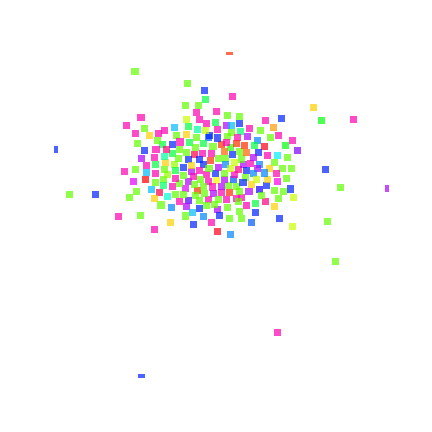

In [299]:
from sklearn.cluster import MiniBatchKMeans


##### Run k-Means clustering algorithm and plot clusters

kmeans = MiniBatchKMeans(n_clusters=30,random_state=RS)
%time labels = kmeans.fit_predict(X)
plot_tsne(tsne, labels, s=50, cmap='hsv')

##### Each color corresponds to a cluster of images found by the KMeans algorithm


### As example, below are shown images from cluster 19

<IPython.core.display.Javascript object>


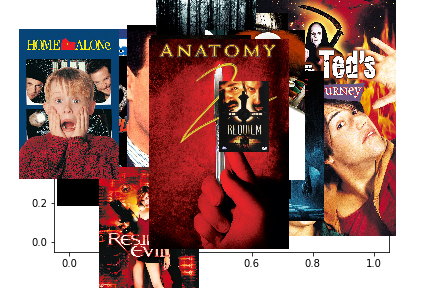

In [388]:
image_path=[]

del image_path[:]

fig, ax = plt.subplots()


ClusterImageId=[]

del ClusterImageId[:]

##### Loop over posters, check if they are in specific cluster

for idx, image in enumerate(posterpathTable):

    if labels[idx]==19:
        
    
        image_path=get_sample_data(posterpathTable[idx])

        imscatter(x[idx], y[idx], image_path, zoom=0.1, ax=ax)
        
        ClusterImageId.append(idx)
        
##### Plot image belonging to the specific cluster
    
ax.plot(x, y)
plt.show()

### 5. Visualize filters of VGG16 fc2 layer

In [305]:
##### Image Ids in the cluster
ClusterImageId

[6,
 14,
 19,
 20,
 45,
 52,
 56,
 61,
 64,
 94,
 96,
 111,
 115,
 117,
 121,
 135,
 144,
 145,
 151,
 152,
 172,
 184,
 185,
 188,
 224,
 227,
 236]

In [ ]:
##### As example let's call here the image with index number 135

from io import BytesIO
from PIL import Image
from keras.preprocessing import image

##### Load and resize image
response = requests.get(posterpathTable[135])

img = image.load_img(BytesIO(response.content))
if img.mode == 'L' or img.mode == 'RGBA':
    img = img.convert('RGB')
img = img.resize((224, 224), Image.ANTIALIAS)
        
        
        
xi = image.img_to_array(img)
xi = np.expand_dims(xi, axis=0)
xi = preprocess_input(xi)

In [ ]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.'''
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

##### Dimensions of the generated pictures for each filter.
img_width = 224
img_height = 224

##### The name of the layer we want to visualize

layer_name = 'fc2'

##### Function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

##### Build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet')
print('Model loaded.')

model.summary()

##### Placeholder for the input images
input_img = model.input

##### Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []

##### Loop over the 4096 filters

for filter_index in range(0, 4096):
    
   
    print('Processing filter %d' % filter_index)
    start_time = time.time()

##### We build a loss function that maximizes the activation
##### of the nth filter of the layer considered

    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, filter_index])

##### We compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

##### Normalization trick: we normalize the gradient
    grads = normalize(grads)

##### This function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

##### Step size for gradient ascent
    step = 1.

    
    input_img_data = xi

##### We run gradient ascent for 20 steps

    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

##### Decode the resulting input image

    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

####W We will stich the best 64 filters on a 8 x 8 grid.
n = 8

##### The filters that have the highest loss are assumed to be better-looking.
##### We will only keep the top 64 filters.

kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

##### Build a black picture with enough space for
##### our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))



In [586]:
##### Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

##### save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)